In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import requests
import datetime
from matplotlib.lines import Line2D
import matplotlib as mpl

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

## 1. Parameters and other variables

In [3]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2022, 12, 1) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*3)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

PLOT_QAP_COUNTERFACTUAL = False  # set to True if you want to investigate QAP rebase

2021-03-15
2022-12-01
2025-11-30


## 2. Setup Simulation Runner

In [4]:
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

In [5]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

In [6]:
def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    df['qap_day_rewards_per_sector'] = SECTOR_SIZE * df['qap_day_network_reward'] / df['network_QAP']
    df['1y_return_per_sector_qap'] = df['qap_day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi_qap'] = df['1y_return_per_sector_qap'] / df['day_pledge_per_QAP']
    
    return df

def compute_blc(rb_onboard_power_pred, renewal_rate_vec_pred, fil_plus_rate_pred):
        
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred])    

    res = get_sector_expiration_stats(start_date, current_date,end_date)
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec[-int(forecast_lenght):],
        fil_plus_rate_pred,
        duration,
        forecast_lenght,
        qap_method='basic'
    )
    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
    
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df,
        known_scheduled_pledge_release_full_vec
    )
    cil_df_roi = add_generated_quantities(cil_df)
    
    assert len(power_df) == len(mint_df)
    assert power_df.iloc[0]['date'] == mint_df.iloc[0]['date']
    
    return_dict = {
        'df': cil_df_roi,
        'renewal_rate_vec': renewal_rate_vec,
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'fil_plus_rate_pred': fil_plus_rate_pred
    }
    
    return return_dict

def plot_blc(data_in, grid, color='b', alpha=1.0, save_fp=None, plot_legends=False, 
             rb_color_override=None, rr_color_override=None):

    df = data_in['df']
    renewal_rate_vec = data_in['renewal_rate_vec']
    rb_onboard_power_pred = data_in['rb_onboard_power_pred']
    
    rb_crossing_above = df[df.network_RBP > df.network_baseline]["date"].iloc[0]
    df_afterfirstcrossing = df[df['date'] > pd.to_datetime(rb_crossing_above)]
    rb_crossing_below_df = df_afterfirstcrossing[df_afterfirstcrossing["network_RBP"] < df_afterfirstcrossing["network_baseline"]]
    if len(rb_crossing_below_df) > 0:
        rb_crossing_below = rb_crossing_below_df["date"].iloc[0]
    else:
        rb_crossing_below = None
    
    # plotting
    max_plottime = df[df['1y_sector_roi'].isnull()].iloc[0]['date']
    df['day_pledge_per_QAP_rollingmedianplot'] = df['day_pledge_per_QAP'].rolling(7).median()
    df['1y_sector_roi_rollingmedianplot'] = df['1y_sector_roi'].rolling(7).median()
    df['1y_sector_roi_qap_rollingmedianplot'] = df['1y_sector_roi_qap'].rolling(7).median()
    
    plt.subplot(grid[0:2, 0:3])
    plt.plot(df.date, df.network_RBP/EIB, color=color, alpha=alpha)
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, color=color, linestyle='--', lw=0.75) #, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.ylabel('Network RBP [EiB]')
    plt.ylim(-1,60)
    plt.xlim(start_date, max_plottime)
    
    plt.subplot(grid[0:2,3:6])
    plt.plot(df['date'], df['day_pledge_per_QAP_rollingmedianplot'], color=color, alpha=alpha)
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, color=color, linestyle='--', lw=0.75) #, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.ylabel('Pledge / 32GiB')
    plt.xlim(start_date, max_plottime)
    
    plt.subplot(grid[2:4,0:3])
    if PLOT_QAP_COUNTERFACTUAL:
        plt.plot(df['date'], df['qap_day_network_reward']-df['day_network_reward'], label='QAP-RBP', color=color, alpha=alpha)
    else:
        plt.plot(df['date'], df['day_network_reward'], color=color, alpha=alpha)
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, color=color, linestyle='--', lw=0.75) #, label='RBP Crossing \n %s' % (rb_crossing_below,))
    plt.xticks(rotation=25)
    plt.ylabel('Minting Rate (FIL/day)')
    plt.xlim(start_date, max_plottime)
    
    plt.subplot(grid[2:4,3:6])
    if PLOT_QAP_COUNTERFACTUAL:
        plt.plot(df['date'], (df['1y_sector_roi_qap_rollingmedianplot']-df['1y_sector_roi_rollingmedianplot'])*100, label='QAP', color=color, alpha=alpha)
    else:
        plt.plot(df['date'], df['1y_sector_roi_rollingmedianplot']*100, label='RBP', color=color, alpha=alpha)
    if rb_crossing_below is not None:
        plt.axvline(rb_crossing_below, color=color, linestyle='--', lw=0.75) #, label='RBP Crossing \n %s' % (rb_crossing_below,))
    
    plt.xticks(rotation=25)
    plt.ylabel('1Y Sector ROI (%)')
    plt.xlim(start_date, max_plottime)
    
    
    # inputs plotting
    if rr_color_override is not None:
        ccc = rr_color_override
    else:
        ccc = color
    
    t_cur = df[df['date'] >= current_date]
    plt.subplot(grid[4,3:6])
    
    plt.plot(t_cur.date, renewal_rate_vec[len(historical_renewal_rate):], color=ccc)
    plt.xticks(rotation=25)
    plt.ylabel('Renewal\nRate')
    plt.xlim(start_date, max_plottime)

    if rb_color_override is not None:
        ccc = rb_color_override
    else:
        ccc = color
    plt.subplot(grid[4,0:3])
    if isinstance(rb_onboard_power_pred, numbers.Number):
        plt.plot(t_cur.date, np.ones(forecast_lenght)*rb_onboard_power_pred, color=ccc)
    else:
        plt.plot(t_cur.date, rb_onboard_power_pred, color=ccc)
    plt.ylabel('RBP Onboarding\n[PiB/Day]')
    plt.xticks(rotation=25)
    plt.xlim(start_date, max_plottime)

    
    if save_fp:
        plt.savefig(save_fp)

## 3. Plot Scenarios

In [7]:
# scenario_params = curated.forecast_onboard_high_rr_median_fpr_median_scenario(forecast_lenght)
delta = 0.05
# pct_max_vec = np.concatenate([[0.01], np.arange(delta, 1.0, delta), [0.99]])
pct_max_vec = np.arange(0.1, 1.0, delta)
target_max_vec = [180]

results = {}
for pct_max in tqdm(pct_max_vec):
    for target in target_max_vec:
        sp = curated.forecast_smooth_scenario(forecast_lenght,
                                              pct_max,
                                              target,
                                              rb_onboard_setting = 'smooth_pcttarget',
                                              renewal_rate_setting = 'smooth_pcttarget',
                                              filplus_rate_setting = 'smooth_pcttarget')
        df = compute_blc(sp['rb_onboard_power'], sp['renewal_rate'], sp['filplus_rate'])
        k = '%0.02f,%d' % (pct_max, target)
        results[k] = df

  0%|          | 0/18 [00:00<?, ?it/s]

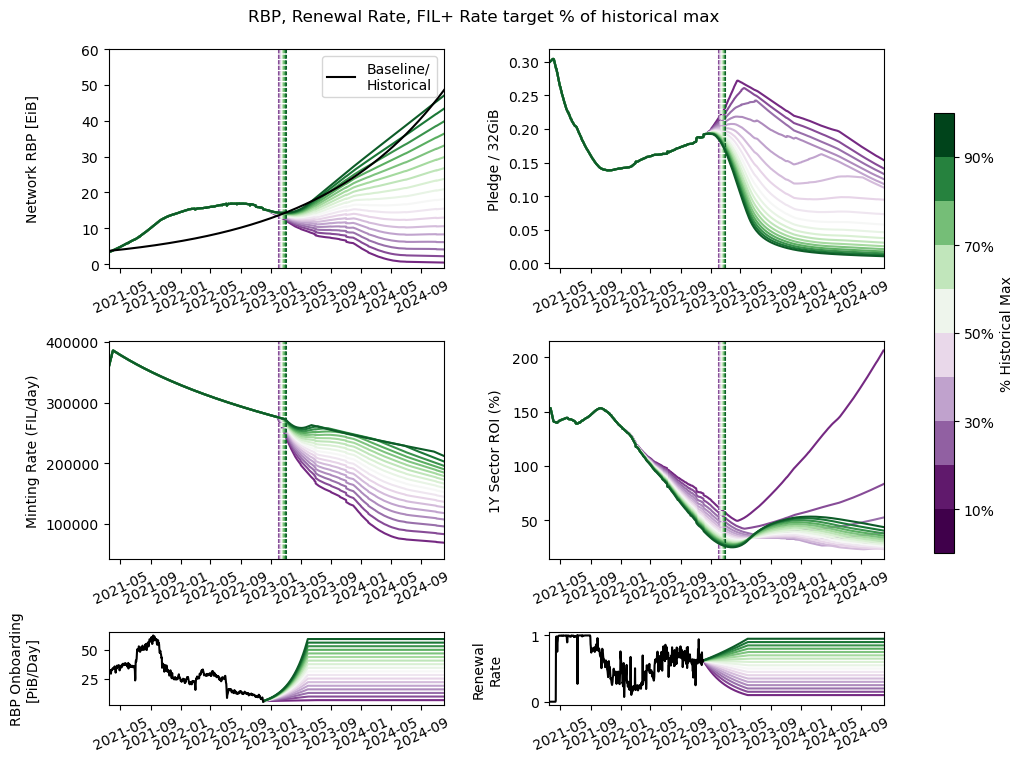

In [8]:
colors=cm.get_cmap("PRGn")

fig = plt.figure(figsize=(10,8))
grid = plt.GridSpec(5, 6, wspace=2.5, hspace=1)

target_max = 180
handles = []
for pct_max in pct_max_vec:
    cc = colors(pct_max)
    res = results[('%0.02f,%d') % (pct_max,target_max)]
    plot_blc(res, grid, color=cc, alpha=1.0, plot_legends=False)
    dff = res['df']

plt.subplot(grid[0:2, 0:3])
plt.plot(dff.date, dff.network_baseline/EIB, color='k', label='Baseline/\nHistorical')
plt.legend()

plt.subplot(grid[4, 0:3])
# plt.plot(t, dff['day_onboarded_rb_power_pib'], color='k')
plt.plot(fil_stats_df.date, fil_stats_df['day_onboarded_rb_power_pib'], color='k', label='Historical')
# plt.legend()

plt.subplot(grid[4, 3:6])
t = dff[dff['date']<=current_date-datetime.timedelta(days=1)].date
plt.plot(t, historical_renewal_rate, color='k', label='Historical')
# plt.legend()

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.30, 0.02, 0.55])
vmin = min(pct_max_vec)
vmax = max(pct_max_vec)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
delta = 0.1
cbar = fig.colorbar(sm, ticks=[0.1, 0.3, 0.5, 0.7, 0.9], 
                    boundaries=np.arange(vmin-delta,vmax+delta,delta),
                    cax=cbar_ax,
                    label='% Historical Max')
cbar.ax.set_yticklabels(['10%', '30%', '50%', '70%', '90%']) 

# plt.subplot(grid[0:2, 3:6])
# plt.yscale('log')

# plt.subplot(grid[2:4, 3:6])
# plt.yscale('log')

fig.align_labels()
plt.suptitle('RBP, Renewal Rate, FIL+ Rate target % of historical max')
plt.tight_layout()
plt.subplots_adjust(top=.93)
plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'baseline_crossing', 'smooth_ramp_targetdays_%d.png' % (target_max,)),
           dpi=300, bbox_inches = "tight")

In [9]:
# scenario_params = curated.forecast_onboard_high_rr_median_fpr_median_scenario(forecast_lenght)
delta = 0.05
pct_max_vec = np.arange(0.1, 1.0, delta)
target_max_vec = [180]

results = {}
for pct_max in tqdm(pct_max_vec):
    for target in target_max_vec:
        sp = curated.forecast_smooth_scenario(forecast_lenght,
                                              pct_max,
                                              target,
                                              rb_onboard_setting = 'historical_median',
                                              renewal_rate_setting = 'smooth_pcttarget',
                                              filplus_rate_setting = 'historical_median')
        df = compute_blc(sp['rb_onboard_power'], sp['renewal_rate'], sp['filplus_rate'])
        k = '%0.02f,%d' % (pct_max, target)
        results[k] = df

  0%|          | 0/18 [00:00<?, ?it/s]

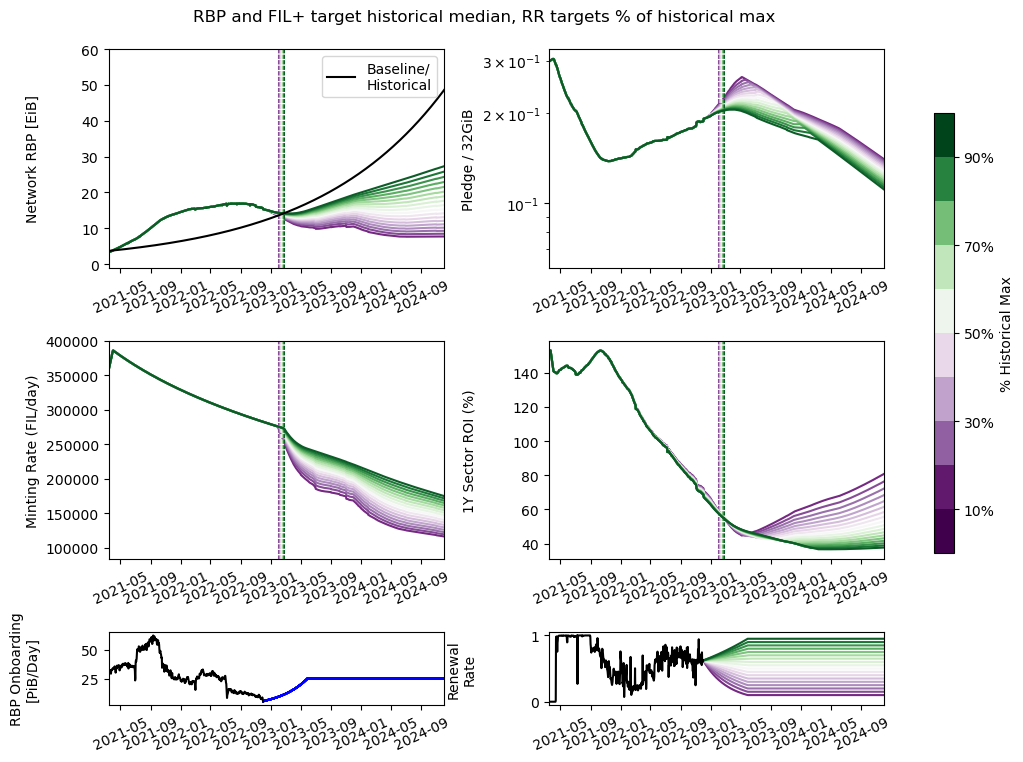

In [10]:
colors=cm.get_cmap("PRGn")

fig = plt.figure(figsize=(10,8))
grid = plt.GridSpec(5, 6, wspace=2.5, hspace=1)

target_max = 180
handles = []
for pct_max in pct_max_vec:
    cc = colors(pct_max)
    res = results[('%0.02f,%d') % (pct_max,target_max)]
    plot_blc(res, grid, color=cc, alpha=1.0, plot_legends=False, rb_color_override='blue')
    dff = res['df']

plt.subplot(grid[0:2, 0:3])
plt.plot(dff.date, dff.network_baseline/EIB, color='k', label='Baseline/\nHistorical')
plt.legend()

plt.subplot(grid[4, 0:3])
# plt.plot(t, dff['day_onboarded_rb_power_pib'], color='k')
plt.plot(fil_stats_df.date, fil_stats_df['day_onboarded_rb_power_pib'], color='k', label='Historical')
# plt.legend()

plt.subplot(grid[4, 3:6])
t = dff[dff['date']<=current_date-datetime.timedelta(days=1)].date
plt.plot(t, historical_renewal_rate, color='k', label='Historical')
# plt.legend()

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.30, 0.02, 0.55])
vmin = min(pct_max_vec)
vmax = max(pct_max_vec)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
delta = 0.1
cbar = fig.colorbar(sm, ticks=[0.1, 0.3, 0.5, 0.7, 0.9], 
                    boundaries=np.arange(vmin-delta,vmax+delta,delta),
                    cax=cbar_ax,
                    label='% Historical Max')
cbar.ax.set_yticklabels(['10%', '30%', '50%', '70%', '90%']) 

plt.subplot(grid[0:2, 3:6])
plt.yscale('log')

fig.align_labels()
plt.suptitle('RBP and FIL+ target historical median, RR targets % of historical max')
plt.tight_layout()
plt.subplots_adjust(top=.93)
plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'baseline_crossing', 'rr_targetdays_%d.png' % (target_max,)),
           dpi=300, bbox_inches = "tight")

In [11]:
# scenario_params = curated.forecast_onboard_high_rr_median_fpr_median_scenario(forecast_lenght)
delta = 0.05
pct_max_vec = np.arange(0.1, 1.0, delta)
target_max_vec = [180]

results = {}
for pct_max in tqdm(pct_max_vec):
    for target in target_max_vec:
        sp = curated.forecast_smooth_scenario(forecast_lenght,
                                              pct_max,
                                              target,
                                              rb_onboard_setting = 'smooth_pcttarget',
                                              renewal_rate_setting = 'historical_median',
                                              filplus_rate_setting = 'historical_median')
        df = compute_blc(sp['rb_onboard_power'], sp['renewal_rate'], sp['filplus_rate'])
        k = '%0.02f,%d' % (pct_max, target)
        results[k] = df

  0%|          | 0/18 [00:00<?, ?it/s]

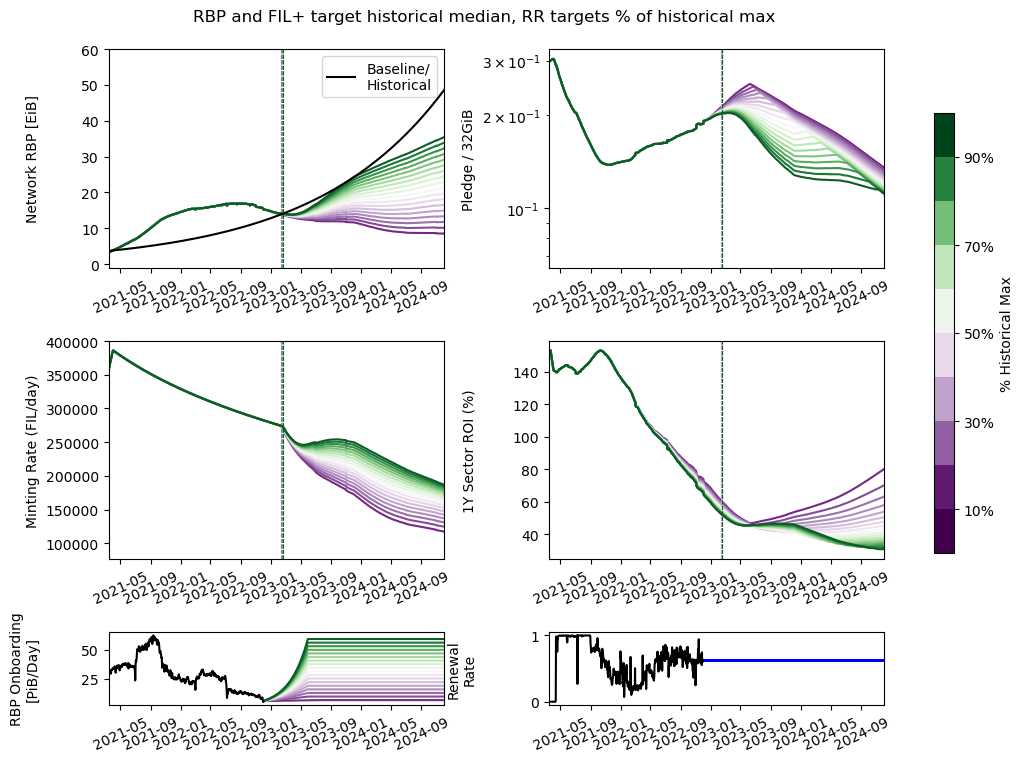

In [12]:
colors=cm.get_cmap("PRGn")

fig = plt.figure(figsize=(10,8))
grid = plt.GridSpec(5, 6, wspace=2.5, hspace=1)

target_max = 180
handles = []
for pct_max in pct_max_vec:
    cc = colors(pct_max)
    res = results[('%0.02f,%d') % (pct_max,target_max)]
    plot_blc(res, grid, color=cc, alpha=1.0, plot_legends=False, rr_color_override='blue')
    dff = res['df']

plt.subplot(grid[0:2, 0:3])
plt.plot(dff.date, dff.network_baseline/EIB, color='k', label='Baseline/\nHistorical')
plt.legend()

plt.subplot(grid[4, 0:3])
# plt.plot(t, dff['day_onboarded_rb_power_pib'], color='k')
plt.plot(fil_stats_df.date, fil_stats_df['day_onboarded_rb_power_pib'], color='k', label='Historical')
# plt.legend()

plt.subplot(grid[4, 3:6])
t = dff[dff['date']<=current_date-datetime.timedelta(days=1)].date
plt.plot(t, historical_renewal_rate, color='k', label='Historical')
# plt.legend()

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.30, 0.02, 0.55])
vmin = min(pct_max_vec)
vmax = max(pct_max_vec)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
delta = 0.1
cbar = fig.colorbar(sm, ticks=[0.1, 0.3, 0.5, 0.7, 0.9], 
                    boundaries=np.arange(vmin-delta,vmax+delta,delta),
                    cax=cbar_ax,
                    label='% Historical Max')
cbar.ax.set_yticklabels(['10%', '30%', '50%', '70%', '90%']) 

plt.subplot(grid[0:2, 3:6])
plt.yscale('log')

fig.align_labels()
plt.suptitle('RBP and FIL+ target historical median, RR targets % of historical max')
plt.tight_layout()
plt.subplots_adjust(top=.93)
plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'baseline_crossing', 'rbp_targetdays_%d.png' % (target_max,)),
           dpi=300, bbox_inches = "tight")